# INF200 Lecture No 11

###  23 November 2020

## Today's topics

1. A beautiful example of parallel programming in Python
1. Creating a Graphical User Interface
1. Chutes & Ladders (Stigespillet)

## A beautiful example: Julia, Mandelbrot & Apfelmännchen (and a bit of parallelization)

In [1]:
import numba
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
plt.rcParams['figure.figsize'] = (8, 8)

### Introduction

Consider the function 

$$f_c(z) = z^2 + c$$ 

for complex numbers $z$ and $c$. The behavior of the number series generated by applying this function repeatedly, i.e.,

$$f_c(z_0),\: f_c(f_c(z_0)),\: f_c(f_c(f_c(z_0))),\: \dots$$

were first studied by the French mathematician [Gaston Julia](https://en.wikipedia.org/wiki/Gaston_Julia). 

The [Mandelbrot set](https://en.wikipedia.org/wiki/Mandelbrot_set) is the set of all $c\in\mathbb{C}$ for which the Julia series iterated from $z_0=0$ does not diverge, i.e., if 
$$z_{n+1} = z_n^2+c$$
fulfills
$$\left|z_n\right| \leq 2 \quad\forall n\;.$$
This set was first studied with the help of computers by the Polish-French-American mathematician [Benoit Mandelbrot](https://en.wikipedia.org/wiki/Benoit_Mandelbrot). It is a [fractal](https://en.wikipedia.org/wiki/Fractal), and due to its shape known as "Apfelmännchen" in German ("little apple man").

#### Some sample iterations

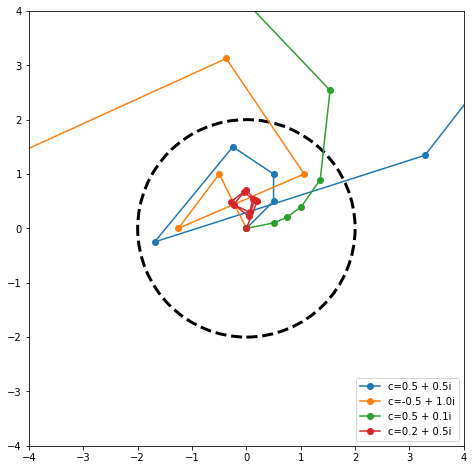

In [2]:
for c in [0.5+0.5j, -0.5+1j, 0.5+0.1j, 0.2+0.5j]:
    z = np.NaN * np.ones(10, dtype=complex)
    z[0] = 0
    for n in range(len(z)-1):
        z[n+1] = z[n]**2 + c
        if abs(z[n+1]) > 10:
            break
    plt.plot(z.real, z.imag, 'o-', label='c={} + {}i'.format(c.real, c.imag))
plt.legend(loc='lower right');
plt.xlim(-4, 4);
plt.ylim(-4, 4);
plt.gca().set_aspect('equal');
plt.gca().add_patch(plt.Circle((0, 0), radius=2, facecolor='none', edgecolor='black', lw=3, ls='--'));

### A serial Python implementation

In [3]:
def mandel_plot(x, y, m, figsize=(8, 8), cmap=cm.jet_r):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.pcolormesh(x, y, m, cmap=cmap, norm=colors.LogNorm(), shading='nearest');
    ax.set_aspect('equal');

In [4]:
@numba.jit
def mandel_iter(x, y, max_iter):
    c = complex(x, y)
    z = 0.0j
    for n in range(max_iter):
        z = z * z  + c
        if abs(z) > 2:
            return n + 1
    return max_iter

def mandel_driver(xmin, xmax, ymin, ymax, width, height, max_iter=500, plot=True):
    x = np.linspace(xmin, xmax, num=width)
    y = np.linspace(ymin, ymax, num=height)
    r = np.empty((height, width))
    for i in range(height):
        for j in range(width):
            r[i, j] = mandel_iter(x[j], y[i], max_iter)
    if plot:
        mandel_plot(x, y, r)
    return r, x, y

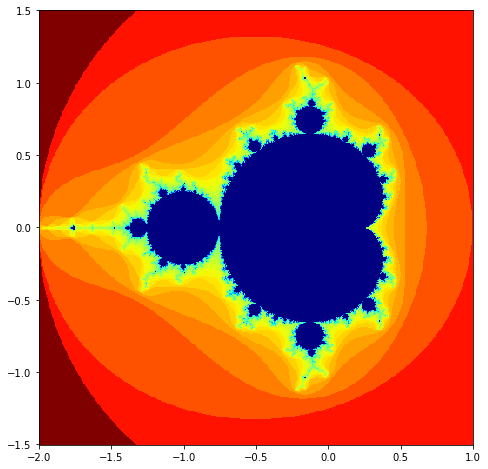

In [5]:
mandel_driver(-2, 1, -1.5, 1.5, 500, 500, max_iter=500);

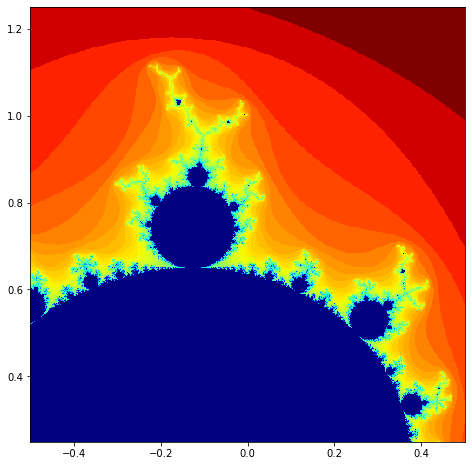

In [6]:
mandel_driver(-0.5, 0.5, 0.25, 1.25, 500, 500, max_iter=500);

- The Mandelbrot set is a *fractal* that is self-similar at all length scales

### Division of labor

- If we want to parallelize, we need to divide the computation into separate tasks
- In principle trivial here: each $c$ is independent of all other
- But: would lead to very many, very small tasks
- Need to group into larger tasks
- Simplest: one line (fixed value of $\Im(c)$) is one task
- Implement first in serial code
- Vectorize iteration function at the same time

In [7]:
@numba.vectorize
def mandel_vec_iter(x, y, max_iter=500):
    c = complex(x, y)
    z = 0.0j
    for n in range(max_iter):
        z = z * z  + c
        if abs(z) > 2:
            return n + 1
    return max_iter

def mandel_line(xmin, xmax, width, y, max_iter):
    x = np.linspace(xmin, xmax, width)
    return mandel_vec_iter(x, y, max_iter)
    
def mandel_line_driver(xmin, xmax, ymin, ymax, width, height, max_iter=500, plot=True):
    x = np.linspace(xmin, xmax, num=width)
    y = np.linspace(ymin, ymax, num=height)
    r = np.empty((height, width))
    for i in range(height):
        r[i, :] = mandel_line(xmin, xmax, width, y[i], max_iter)
    if plot:
        mandel_plot(x, y, r)
    return r, x, y

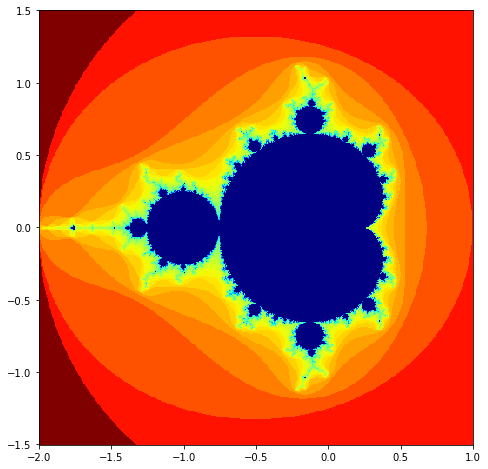

In [8]:
mandel_line_driver(-2, 1, -1.5, 1.5, 500, 500, max_iter=500);

- Seems to work!

### A parallel implementation

- We use Python's [multiprocessing](https://docs.python.org/3.6/library/multiprocessing.html) module
- Runs parallel tasks in independent *processes*
- Actual parallel processing
- Tasks run as parallel *processes*: Must place code in modules and import, running directly from notebook cells does not work
- Activate [autoreloading](https://ipython.readthedocs.io/en/stable/) of modules in Notebook

In [9]:
%load_ext autoreload
%autoreload 1

In [16]:
%%writefile paramandel.py

import multiprocessing as mp
import numba
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import time

def mandel_plot(x, y, m, figsize=(6, 6), cmap=cm.jet_r):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.pcolormesh(x, y, m, cmap=cmap, norm=colors.LogNorm(), shading='nearest');
    ax.set_aspect('equal');
    
@numba.vectorize
def mandel_iter(x, y, max_iter=500):
    c = complex(x, y)
    z = 0.0j
    for n in range(max_iter):
        z = z * z  + c
        if abs(z) > 2:
            return n + 1
    return max_iter

def mandel_line(xmin, xmax, width, y, max_iter):
    x = np.linspace(xmin, xmax, width)
    return mandel_iter(x, y, max_iter)
    
def mandel_pool_driver(xmin, xmax, ymin, ymax, width, height, max_iter=500, n_proc=4, plot=True):
    x = np.linspace(xmin, xmax, num=width)
    y = np.linspace(ymin, ymax, num=height)
    with mp.Pool(processes=n_proc) as pool:
        r = np.array(pool.starmap(mandel_line,
                                  ( (xmin, xmax, width, yy, max_iter) for yy in y )
                                 )
                    )
    if plot:
        mandel_plot(x, y, r)
        
    return r, x, y

Overwriting paramandel.py


In [17]:
%aimport paramandel
from paramandel import mandel_pool_driver

In [18]:
mandel_pool_driver(-2, 1, -1.5, 1.5, 500, 500, max_iter=500);

- Looks good as well!
- Should do explicit comparison of results, but we trust the figures for now

### Benchmarks

#### Initial serial version

In [16]:
%timeit -r 3 -n 1 mandel_driver(-2, 1, -1.5, 1.5, 1000, 1000, max_iter=5000, plot=False);

5.06 s ± 23.3 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


#### Serial version with linewise approach and vectorized iteration

In [17]:
%timeit -r 3 -n 1 mandel_line_driver(-2, 1, -1.5, 1.5, 1000, 1000, max_iter=5000, plot=False);

4.63 s ± 78.1 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


- Sligthly faster, presumably due to vectorized iteration

#### Parallel version, single process

In [18]:
%%timeit -r 3 -n 1 
mandel_pool_driver(-2, 1, -1.5, 1.5, 1000, 1000, 
                   max_iter=5000, plot=False, n_proc=1);

4.82 s ± 104 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


- Slightly slower, overhead due to process management

#### Parallel version, two processes

In [19]:
%%timeit -r 3 -n 1 
mandel_pool_driver(-2, 1, -1.5, 1.5, 1000, 1000, 
                   max_iter=5000, plot=False, n_proc=2);

2.63 s ± 54 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


- Almost speed-up by factor 2

#### Parallel version, four processes

In [20]:
%%timeit -r 3 -n 1 
mandel_pool_driver(-2, 1, -1.5, 1.5, 1000, 1000, 
                   max_iter=5000, plot=False, n_proc=4);

1.47 s ± 1.15 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


- Almost halved again
- Speed-up compared to single process

In [21]:
4.82/1.47

3.2789115646258504

- Only factor 3.3, while we would hope for a factor 4
- Sub-linear speed-up may be due to uneven distribution of labor
- We may want to explore other schemes to distribute work to processes

#### Benchmark on computer with 24 cores

- Benchmark data below was obtained on a system with two Intel(R) Xeon(R) CPU E5-2680 v3 @ 2.50GHz processors
- Each CPU has 12 hardware cores, so the system has a total of 24 hardware cores
- The CPUs support *hyperthreading*, so each physical core pretends to provide two cores
- Data are from there repetitions for $5000\times 5000$ matrices with up to $5000$ iterations

In [22]:
n_proc = [1, 2, 4, 8, 12, 24, 32, 48]
t = [245, 125, 67, 37.4, 26.7, 14.2, 13., 11.6]

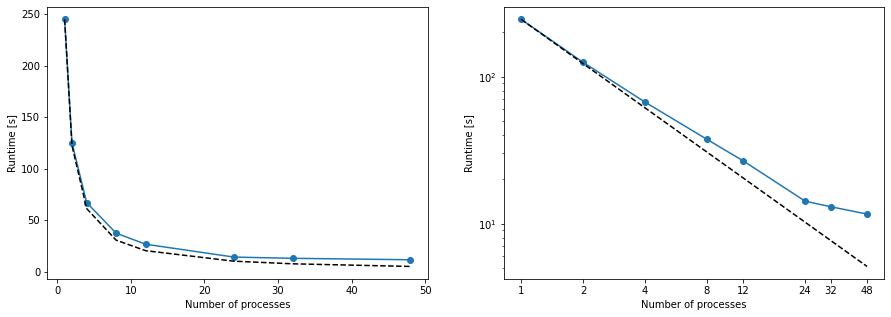

In [23]:
fig, (axn, axg) = plt.subplots(1, 2, figsize=(15, 5));
axn.plot(n_proc, t, 'o-');
axn.plot(n_proc, 245/np.array(n_proc), 'k--');
axn.set_xlabel('Number of processes');
axn.set_ylabel('Runtime [s]');

axg.loglog(n_proc, t, 'o-');
axg.loglog(n_proc, 245/np.array(n_proc), 'k--');
axg.set_xlabel('Number of processes');
axg.set_ylabel('Runtime [s]');
axg.set_xticks(n_proc);
axg.set_xticklabels(n_proc);
axg.tick_params(axis='x', which='minor', bottom=False);

- Errorbars were smaller than symbol size
- Good scaling up to 24 processes, but not perfect
- Scaling beyond 24 processes much worse
    - here we use the virtual second cores
    - do not help much for our code since code is *very* CPU intensive
- This is an example of *strong scaling*: fixed problem size, increasing number of processes

### PyCL

The following PyCL imlementation taken from the following no longer available page: https://www.ibm.com/developerworks/community/blogs/jfp/entry/How_To_Compute_Mandelbrodt_Set_Quickly?lang=en.

Requires `conda install -c conda-forge pyopencl`

In [19]:
import pyopencl as cl

In [20]:
class MandelGPU:
    def __init__(self):
        self.ctx = cl.create_some_context(interactive=True)
        self.queue = cl.CommandQueue(self.ctx)

        self.prg = cl.Program(self.ctx, """
            #pragma OPENCL EXTENSION cl_khr_byte_addressable_store : enable
            __kernel void mandelbrot(__global float2 *q,
                             __global ushort *output, ushort const maxiter)
            {
                int gid = get_global_id(0);
                float nreal, real = 0;
                float imag = 0;
                output[gid] = 0;
                for(int curiter = 0; curiter < maxiter; curiter++) {
                    nreal = real*real - imag*imag + q[gid].x;
                    imag = 2* real*imag + q[gid].y;
                    real = nreal;
                    if (real*real + imag*imag > 4.0f){
                         output[gid] = curiter;
                         break;
                    }
                }
            }
            """).build()


    def _run(self, q, maxiter):
        output = np.empty(q.shape, dtype=np.uint16)

        mf = cl.mem_flags
        q_opencl = cl.Buffer(self.ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=q)
        output_opencl = cl.Buffer(self.ctx, mf.WRITE_ONLY, output.nbytes)

        self.prg.mandelbrot(self.queue, output.shape, None, q_opencl,
                            output_opencl, np.uint16(maxiter))

        cl.enqueue_copy(self.queue, output, output_opencl).wait()
    
        return output
    
    def run(self, xmin, xmax, ymin, ymax, width, height, max_iter=500, plot=True):
        x = np.linspace(xmin, xmax, num=width, dtype=np.float32)
        y = np.linspace(ymin, ymax, num=height, dtype=np.float32)
        c = x + y[:,None]*1j
        c = np.ravel(c)
        n = self._run(c, max_iter)
        n = n.reshape((width, height))
                
        if plot:
            mandel_plot(x, y, n)
        return n, x, y

In [21]:
mg = MandelGPU()

Choose platform:
[0] <pyopencl.Platform 'Apple' at 0x7fbbf318a4d0>


Choice [0]: 


Choose device(s):
[0] <pyopencl.Device 'Intel(R) Core(TM) i5-1038NG7 CPU @ 2.00GHz' on 'Apple' at 0x7fbc0030c720>
[1] <pyopencl.Device 'Intel(R) Iris(TM) Plus Graphics' on 'Apple' at 0x7fbc0030c740>


Choice, comma-separated [0]: 1


Set the environment variable PYOPENCL_CTX=':1' to avoid being asked again.


In [22]:
%timeit mg.run(-2, 1, -1.5, 1.5, 1000, 1000, 5000, plot=False);

34.4 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


- Much faster than on CPU
- But: Uses only 32-bit floats, not 64 bit as CPU, so lower resolution

In [23]:
mg.run(-2, 1, -1.5, 1.5, 1000, 1000, 5000, plot=True);

-------------

## Creating a GUI

- Software can be easier to use with a graphical user interface (GUI)
- Many different GUI toolkits available
- Some examples
    - [TkInter](https://wiki.python.org/moin/TkInter) based on [Tcl/Tk](https://en.wikipedia.org/wiki/Tk_(software))
    - [PyQt](https://www.riverbankcomputing.com/software/pyqt/intro) (pronouced "py-cute") and [PySide2](https://www.qt.io/qt-for-python) based on [Qt](https://www.qt.io)
    - [Kivy](kivy.org)
    - [Dash](https://plot.ly/products/dash/) based on [Plotly](https://plot.ly)
- Serving applications via the web
    - Frequently, today, GUIs run in a web browser, interacting with a backend running on a remote server (e.g. GoogleDocs)
    - One can also run a a server locally (as with Jupyter notebooks)
    - A popular Python package for this purpose is [Flask](http://flask.pocoo.org)
    - [JSON](https://en.wikipedia.org/wiki/JSON) (JavaScript Object Notation) is commonly used to transfer information between server and client
    - Client software commonly written in [JavaScript](https://en.wikipedia.org/wiki/JavaScript)
        - Allows considerable "intelligence" on the client side
    - Many frameworks support development, e.g.
        - [AngularJS](https://angular.io) (from Google)
        - [ReactJS](https://reactjs.org) (from Facebook)
        - [three.js](https://threejs.org) (for 3D graphics)
        - [Django](https://www.djangoproject.com) (Python-based)

### Model-View-Controller Pattern

<img src="figures/MVC-Process.svg" width=30%> 
(By RegisFrey - Own work, Public Domain, https://commons.wikimedia.org/w/index.php?curid=10298177)

- *Model* is data and operations of underlying application, e.g., a simulation
- *View* presents model to user, different views are possible
- *Controller* allows user to modify model
- View and Controller form the user interface
- Clean separation of model from interface important for flexibility and maintainability

### Example: NEST Instrumentation App

- Permits users to connect stimulation and recording devices to a neuronal network
- Developed by Stine Vennemo and Håkon Mørk for the Human Brain Project

<img src="figures/3D_poisson_connected.png" width=80%>

#### Implementation

<img src="figures/NEST_App_Implementation.png" width=80%>

## Practical examples

- We will implement simple GUIs using Matplotlib GUI support

### Key elements

- **Figure** holds a Matplotlib GUI
- **Canvas** is essentially the "paper" the figure is drawn on
- **Axes** are boxes that can hold graphical elements, e.g., plots, text, or widgets
- **Wigdets** are elements of a GUI, e.g., buttons, sliders, selection tools
- **Events** are triggered when the user clicks or moves the mouse, or types
- **Callback** functions are called when events occur
- **Infinite loop** runs until application terminates
    - events trigger callbacks
    - callbacks do things
    
### Examples
- `gui_examples/demo_gui.py`
- `gui_examples/mandel_gui_with_doc.py`

### Documentation

- https://matplotlib.org/gallery/widgets/slider_demo.html
- https://matplotlib.org/users/event_handling.html
- https://matplotlib.org/api/widgets_api.html
- https://matplotlib.org/examples/widgets/buttons.html

-------------

## Chutes & Ladders

[Chutes & Ladders](https://en.wikipedia.org/wiki/Snakes_and_Ladders),
also known as Snakes & Ladders or as “Stigespillet” in Norwegian, is a
popular childrens board game. It is played on a board of 90 enumerated
squares, where some squares are connect by ladders and others by
chutes.

The rules are as follows:

1. Each player has one figure, which starts at the imaginary square 0 to the left of square 1.
1. Each time it is a player’s turn, she throws a six-sided die and moves her figure the given number of fields forward.
1. If the figure stops on a field at the bottom of a ladder, the figure moves immediately up the ladder.
1. If the figure stops on a field at the top of a chute, the figure moves immediately down the chute.
1. The game ends when the first player reaches (or passes) field 90.

A *move* in the game is defined as the complete process of rolling the die, moving forward and moving
up/down a ladder/chute when necessary. 

This game has a number of interesting properties:

- The movement of each player is completely independent of the
  movements of all other players as long as no player reaches
  field 90.
- Each move is completely determined by the current position of the figure and the cast of the die.

In particular, each move does not depend on the past moves of the
figure in any other way than through the current position of the
figure. Because the future depends on the past only through the
present position of the figure, the movement of the figure is a
[Markov process](https://en.wikipedia.org/wiki/Markov_process). Markov
processes play an important role in modeling of a large range of
systems in biology, physics, economy etc.

An interesting question is how long games last, i.e., how many moves a
player has to make before reaching or passing field 90. The number of
moves will vary from game to game, and we are interested in the
probability distribution for the duration of the game. This is a
*first-passage-time problem*, an important class of problems first
studied by Erwin Schrödinger in 1915 (Zur Theorie der Fall- und
Steigversuche an Teilchen mit Brownscher Bewegung. *Physikalische
Zeitschrift* **16**:289–295, 1915).

### Simulation code

See file `chutes.py`.

------

## Simulation study: Effect of Player Number on Game Duration

Analyse the effect of the number of players on the duration of the Chutes & Ladders game on a board of 90 squares with seven chutes and seven ladders.

The analysis is performed using the `chutes` Python module.

## Data collection

We generate data for 1, 2, 4 and 8 players. Since all these simulations are parts of a single randomized experiment, we seed the random number generator only once; alternatively, we could have used a different random number generator seed for each number of players.

In [1]:
import random
from chutes import multiple_games

In [2]:
seed = 1234567
num_games = 1000
num_players = [1, 2, 4, 8]

In [3]:
random.seed(seed)
durations = {num: multiple_games(num_games, num) for num in num_players}

## Data analysis

To determine the limits of our histograms, we first look at the shortest and longest game durations:

In [4]:
import numpy as np

In [5]:
for num, dur in sorted(durations.items()):
    print('Players: {:2d}, Shortest: {:2d}, Mean: {:5.1f}, Longest: {:4d}'.format(
               num, min(dur), np.mean(dur), max(dur)))

Players:  1, Shortest:  4, Mean:  35.5, Longest:  167
Players:  2, Shortest:  4, Mean:  24.1, Longest:   83
Players:  4, Shortest:  4, Mean:  18.0, Longest:   47
Players:  8, Shortest:  4, Mean:  14.0, Longest:   32


We notice that the shortest game duration is 4, which is the optimum. We also see that game duration is dropping with number of players, which is plausible.

### Creating histograms

Since the longest game observed is 167 moves, 200 is a reasonable choice for the upper limit of our histograms. We can either create histograms directly when plotting using Matplotlib's `hist()` function. Here, we use the `histogram()` function from Numpy. This allows us to create the histograms once and then plot them in different ways.

When defining the bin edges, we need to take into account precisely how `histogram()` defines its bins, which is described in the documentation of the function:

        All but the last (righthand-most) bin is half-open.  In other words, if
        `bins` is::

          [1, 2, 3, 4]

        then the first bin is ``[1, 2)`` (including 1, but excluding 2) and the
        second ``[2, 3)``.  The last bin, however, is ``[3, 4]``, which *includes*
        4.

Our data is entirely integer, so if we use `bins = [0, 1, 2, 3, 4, 5, ...]`, then the number of games which ended after 4 moves will be in the bin for interval $[4, 5)$, corresponding to the entry `4` in the `bins` list. That makes sense.

A little technical problem we need to handle is that `histogram()` returns a tuple consisting of the bin counts and the bin borders. We only want to keep the bin counts. Therefore, we keep only the first element of the tuple.

In [6]:
bins = range(201)
hists = {num: np.histogram(dur, bins=bins)[0] for num, dur in durations.items()}

For later plotting, it is interesting to see the maximum values of the histogram counts:

In [8]:
for num, hst in sorted(hists.items()):
    print('Players: {:2d}, Max count: {:4d}'.format(num, max(hst)))

Players:  1, Max count:   39
Players:  2, Max count:   64
Players:  4, Max count:   81
Players:  8, Max count:   84


Note that the maximum count increases with player number. This is not implausible, because durations become shorter for more players and thus more compressed.

### Plotting the histograms

We now import Matplotlib to plot the histograms. We also use the `%matplotlib` Jupyter magic to ensure that our figures are placed in the notebook.

In [9]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 4]

Now we plot all histograms, each in a separate figure. We use the subplot command to create several frames in a single figure. Note that subplots are index from 1 (a rare concession to Matlab habits).

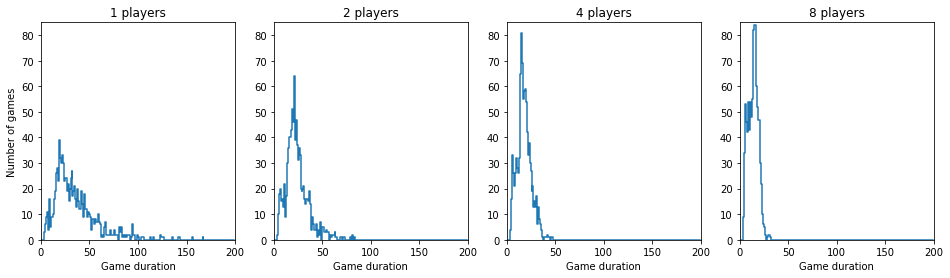

In [10]:
for plot_num, n_players in enumerate(sorted(hists.keys())):
    plt.subplot(1, 4, plot_num+1)
    plt.step(bins[:-1], hists[n_players], where='mid')
    plt.xlim(0, 200)
    plt.ylim(0, 85)
    plt.xlabel('Game duration')
    if plot_num == 0:
        plt.ylabel('Number of games')        
    plt.title('{} players'.format(n_players));

Some comments on the code above:
- `enumerate(['a', 'b', 'c'])` returns a list of tuples `[(0, 'a'), (1, 'b'), (2, 'c')]`, i.e., combining each item with its index. We use that above to get consecutive figure numbers and the number of players
- The histogram counts in `hists` have one element less than `bins`. This is because the last element of `bins` is the *right* border of the last bin. Thus, we need to drop the last element when plotting.
- `step()` plots our graph in staircase fashion, i.e., in proper form for a histogram.
- The `where='mid'` argument to `step()` tells it that the x-value (from `bins`)  gives the centre of the step. That is what we want: the step showing the number of games with 10 steps should be centred about 10.
- We only add a label to the vertical axis of the leftmost plot, to avoid visual clutter.
- The last plot command ends with a semicolon to avoid that the return value from the command is shown in the notebook.

### More histogram plots

Let us now plot the histograms in a single figure, so it becomes easier to compare them. In order to get both the overall picture and a good look at the shorter durations where the diagrams are most interesting, we create two plots with different x-axis limits.

Since we want to create two essentially identical plots, we define a function creating the plot and then run it twice.

In [11]:
def combined_histograms(hists, xlims=[0, 200]):
    for n_players, dur in sorted(hists.items()):
        plt.step(bins[:-1], dur, where='mid', 
                 label='{} players'.format(n_players))
    plt.legend()
    plt.xlim(xlims)
    plt.ylim(0, 85)
    plt.xlabel('Game duration')
    plt.ylabel('Number of games');

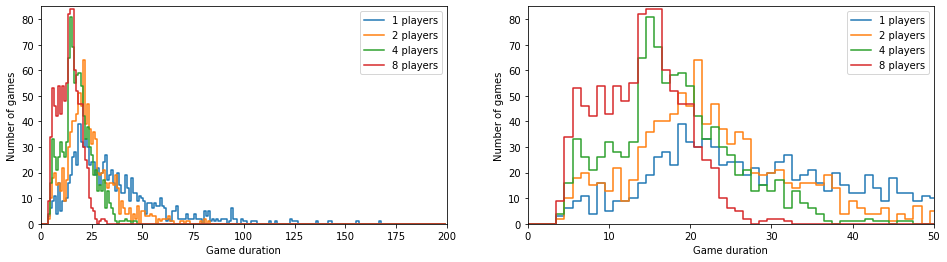

In [12]:
plt.subplot(1, 2, 1)
combined_histograms(hists)
plt.subplot(1, 2, 2)
combined_histograms(hists, xlims=[0, 50])

We can now see clearly how the weight of the distributions shifts towards shorter games.

Some comments on the code above:
- We call `subplot()` outside the function. The function then plots into the area `subplot()` has set up.
- The `label` provides information for the legend. When we plot a line, Matplotlib attaches the label information to the line, and `legend()` then collects this information from the graph.
- The `xlim()` and `ylim()` functions accept two-element lists as well as two arguments.
- Note that we have modified the loop header a bit:
    - We iterate over the `items()` of the `hists` dictionary, i.e., over key-value pairs (player number and array of histogram counts). `sorted()` sorts this for us according to player number, and enumerate then returns a list combining indices with key-value tuples (`<histX>` are the respective histogram arrays):
    
            [(0, (1, <hist1>)), (1, (2, <hist2>)), (2, (4, <hist4>)), (4, (8, <hist8>))]

    - The code
     
            for plot_num, (n_players, dur) in ...
        
      then unpacks these tuples for us.
    - This gives us all data we need in the loop directly, we do not need to index `hists[n_players]` inside the loop. This is considered the most pythonic way of doing things.

---------------



## Chutes & Ladders as a Markov Process


### Background

The movement of the walker is a [Markov process](https://en.wikipedia.org/wiki/Markov_process), because the result of a single move depends only on the current position $j$ of the walker and the roll of the die. The entire history, i.e., *how* the walker got to position $j$ does not matter. Such processes are highly relevant in many branches of science and technology. One example of their use in neuroscience is in my PhD thesis ([Plesser, 1999](http://arken.umb.no/~plesser/publications/HEPlesser_PhD.pdf)). We can use techniques for Markov processes to study the movement of the walker in the Chutes & Ladders game.

Instead of obtaining the distribution of times to goal using simulation, we can also obtain it by numerical computation (or, using, e.g. SymPy, even exact). Let ${p^{(k)}}$ be a vector with elements $p^{(k)}_j$ ($0\leq j \leq G$) representing the probability probability that the walker is at position $j$ after move $k$. As initial conditions, we have
\begin{align}
p^{(0)}_0 &= 1\\
p^{(0)}_j &= 0\quad\mathrm{for}\; j>0
\end{align}
Let $M$ be a matrix that describes the how a single move changes the probabilities for the location of the walker. Specifically, let $M_{ij}$ be the probability that a walker in position $j$ will move to position $i$ in the next move. 
Let us first consider a game without chutes and ladders. The walker will then with equal probability move to one of the next six positions, except for the last few positions on the board, where any move will stop at $G$. We therefore have
\begin{align}
M_{0j} &= 0 \qquad\mathrm{(can\,never\,return\,to\,0)} \\
M_{ij} &= 1/6 \quad\mathrm{for}\; j+1\leq i \leq j+6 \;\mathrm{and}\; i < G\\
M_{Gj} &= 0 \quad\mathrm{for}\; j < G-6 \\
M_{Gj} &= 1 - (G-j-1)/6 \quad\mathrm{for}\; G-6 \leq j < G \\
M_{GG} &= 1\\
M_{ij} &= 0 \quad\mathrm{else}
\end{align}

We can then describe the motion of the walker across the board by the following equation:

\begin{equation}
p^{(k+1)} = M \times p^{(k)} \;.
\end{equation}

To obtain the probability distribution for the time to arrive at the goal $G$, we consider $p^{(k)}_G$, which corresponds to the probability that the walker has reached the goal after at most $k$ moves. If $G=6n$, then the goal can at the earliest be reached after $n$ moves (all sixes, probability $(1/6)^n$), and must at the latest be reached after $G$ moves ($G$ ones, probability $(1/6)^G$), i.e.,

\begin{align}
p^{(k)}_G &= 0 \quad\mathrm{for}\; k < n \\
p^{(n)}_G &= (1/6)^n \\
p^{(G)}_G &= 1
\end{align}

These cases provide test cases. Note that $Q_k=p^{(k)}_G$ is the *cumulative*  probability of arrival by step $k$. The probability for arriving *at* step $k$ is 
$$q_k = Q_k - Q_{k-1}\;.$$

Let us now assume that we have a ladder from $r$ to $s$ (chutes work the same way). Then the probability for the walker to move to $r$ will be $0$, and the corresponding probability will be "moved" to $s$. Specifically, based on matrix $M$ from above, we can defined matrix $L$ as follows:
\begin{align}
L_{rj} &= 0 \quad \forall j \qquad\mathrm{(no\,moves\,to\,r)}\\
L_{sj} &= M_{sj} + M_{rj}\quad \forall j \qquad\mathrm{(moves\,to\,s\,instead\,of\,r)}\\
L_{ij} &= M_{ij}\quad\mathrm{else}
\end{align}

### Implementation

We defined $p$ as an array with one column per time point we are interested in, and one row per position. We add some extra columns to ensure all is stationary after $G$ steps and to avoid confusion about which matrix dimension is what.

In [13]:
p = np.zeros((91, 100))
p[0, 0] = 1

In [14]:
M = np.zeros((91, 91))
M[90, 90] = 1
M[90, 84:90] = np.array([1., 2., 3., 4., 5., 6.]) / 6.
for i in range(1, 90):
    M[i, max(0, i-6):i] = 1./6.

In [15]:
for k in range(1, 100):
    p[:, k] = M @ p[:, k-1]

In [16]:
plt.rcParams['savefig.dpi'] = 120          
plt.rcParams['figure.figsize'] = (12., 6.)

In [17]:
plt.matshow(M);
plt.xlabel('Current board position $j$');
plt.ylabel('Next board position $i$');
plt.title('Transistion matrix for plain board');
ax = plt.colorbar(shrink=0.7);

- The broad band slighly below the diagonal represents normal moves.
- Accumulation of probability in position $G=90$ is visible in the bottom right corner.

In [18]:
plt.matshow(p)
plt.xlabel('Step number $k$');
plt.ylabel('Board position $j$');
plt.title('Evolution of residence probability');
ax = plt.colorbar(shrink=0.7);

#### Improving the figures

- Graphs are a bit difficult to read due to low contrast
- We define a function providing nice plotting
- For details, see the end of this notebook

In [19]:
import matplotlib.cm as cm

def prettymat(m):
    cm7 = cm.get_cmap('YlGnBu_r', 7)
    cm7list = [cm7(i) for i in range(cm7.N)]
    cm7list[0] = [0.9, 0.9, 0.9]
    cm7mod = cm7.from_list('mymap', cm7list, cm7.N)
    plt.matshow(m, cmap=cm7mod)
    cax = plt.colorbar(shrink=0.7);
    cax.set_ticks(np.arange(0., 7.) / 7. + 1./14.);
    cax.set_ticklabels(('0', '1/6', '1/3', '1/2', '2/3', '5/6', '1'));
    plt.xlabel('Current board position $j$');
    plt.ylabel('Next board position $i$');
    plt.title('Transistion matrix for plain board');

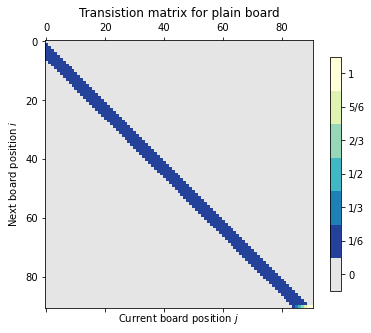

In [20]:
prettymat(M);

In [23]:
from matplotlib.colors import PowerNorm

def prettyprob(p):
    p_cutoff = 0.001
    cm_p = cm.get_cmap('YlGnBu_r')
    plt.matshow(p, cmap=cm_p,
                norm=PowerNorm(gamma=0.2, vmin=p_cutoff, vmax=1))
    plt.xlabel('Step number $k$');
    plt.ylabel('Board position $j$');
    plt.title('Evolution of residence probability');
    cax = plt.colorbar(shrink=0.8, extend='min');
    cax.set_ticks([p_cutoff, 0.002, 0.005, 0.01, 0.02, 0.05, 
                   0.1, 0.2, 0.5, 1.0]);

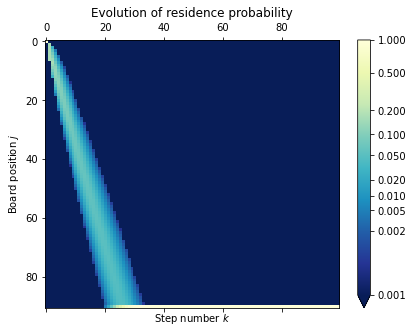

In [24]:
prettyprob(p)

#### Arrival time probabilities

In [25]:
Q = p[90, :]
q = np.zeros_like(Q)   # fiddle a little to avoid zero-indexing trouble
q[1:] = np.diff(Q)

In [29]:
plt.step(range(100), Q, where='mid');
plt.title('Cumulative distribution of arrival times')
plt.xlabel('Number of steps');
plt.ylabel('$Q_k$');

In [30]:
plt.step(range(100), q, where='mid');
plt.title('Distribution of arrival times')
plt.xlabel('Number of steps');
plt.ylabel('$q_k$');

Let's check the border cases

In [31]:
Q[14], Q[15], (1./6.)**15, Q[15]-(1./6.)**15

(0.0, 2.126822490730477e-12, 2.126822490730477e-12, 0.0)

In [32]:
q[90]

0.0

In [33]:
Q[89]-1, Q[90]-1

(-1.5543122344752192e-15, -1.5543122344752192e-15)

In [34]:
(1./6.)**90

9.255235320869914e-71

Okay, probabilities for long game durations are far below numerical precision, therefore we do not see exact values in the tail of the distribution. But the error of $\mathcal{O}(10^{-15})$ is acceptable.

#### Matrix with chutes and ladders

We first define the standard set of chutes and ladders.

In [35]:
cnl = [(1, 40), (8, 10), (36, 52), (43, 62), (49, 79), (65, 82), (68, 85)] + \
      [(24, 5), (33, 3), (42, 30), (56, 37), (64, 27), (74, 12), (87, 70)]

In [36]:
L = M.copy()
for start, dest in cnl:
    L[start, :] = 0.
    L[dest, :] += M[start, :]

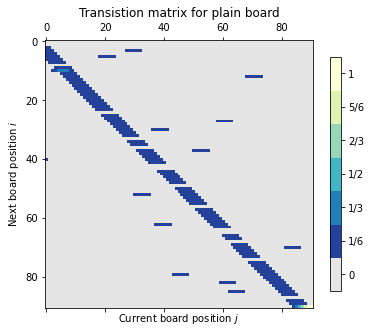

In [37]:
prettymat(L)

- The broad band slighly below the diagonal represents normal moves.
- Stripes above the diagonal represent chutes.
- Stripes below the broad band represent ladders.
- The bright blue bar in the top-left corner is the $8\to 10$ ladder which is so short it overlaps with normal movement.
- The $1	\to 40$ ladder is visible as a single bright blue pixel on row 40.
- Accumulation of probability in position $G=90$ is visible in the bottom right corner.

In [40]:
pL = np.zeros((91, 300))
pL[0, 0] = 1
for k in range(1, pL.shape[1]):
    pL[:, k] = L @ pL[:, k-1]

In [41]:
QL = pL[90]
qL = np.zeros_like(QL)
qL[1:] = np.diff(QL)

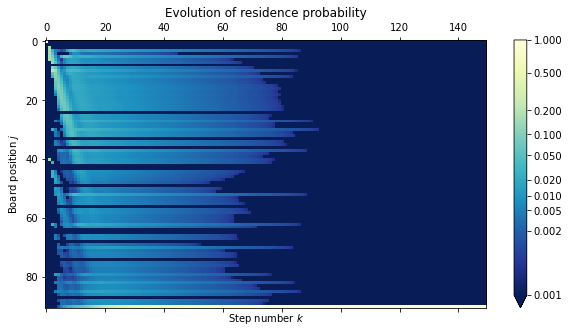

In [42]:
prettyprob(pL[:, :150])

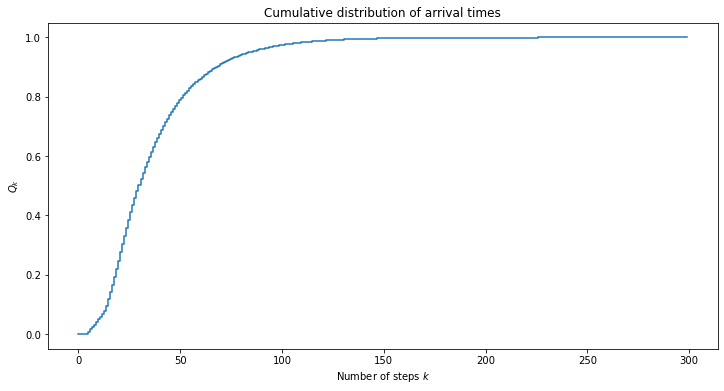

In [43]:
plt.step(range(len(QL)), QL, where='mid');
plt.title('Cumulative distribution of arrival times')
plt.xlabel('Number of steps $k$');
plt.ylabel('$Q_k$');

In [44]:
plt.step(range(len(qL)), qL, where='mid');
plt.title('Distribution of arrival times')
plt.xlabel('Number of steps $k$');
plt.ylabel('$q_k$');

We know that the shortest path is 4 steps, requiring a precise sequence of die casts, i.e., it has probability $6^{-4}$. We can check this:

In [45]:
print("No one should make it in three moves                   :", qL[3])
print("It is possible to make it in four moves                :", qL[4])
print("If there is a single way to do it four moves, we expect:", (1./6.)**4)
print("If there are two ways to do it in four moves, we expect:", 2 * (1./6.)**4)
print("Difference between results and two-ways expectation    :", qL[4] - 2 * (1./6.)**4)

No one should make it in three moves                   : 0.0
It is possible to make it in four moves                : 0.0015432098765432098
If there is a single way to do it four moves, we expect: 0.0007716049382716048
If there are two ways to do it in four moves, we expect: 0.0015432098765432096
Difference between results and two-ways expectation    : 2.168404344971009e-19


So apparently there are two ways to do it in four steps. Inspection of the board reveals the following possibilities:

1. Roll 1, then take ladder from 1 to 40.
1. Roll 3, then take ladder from 43 to 62.
1. Roll 6, then take ladder from 68 to 85.
1. From 85, you can reach 90 by either rolling 5 or 6.

Therefore, there are indeed exactly two ways of reaching the goal with four moves.

Furthermore, we can check that $Q_k	\to 1$ for $k	\to\infty$:

In [46]:
1 - QL[-1]

5.44515939848722e-06

This indicates convergence to $1$, but at the same time a rather long tail. We can plot semilogarithmically to see the tail better:

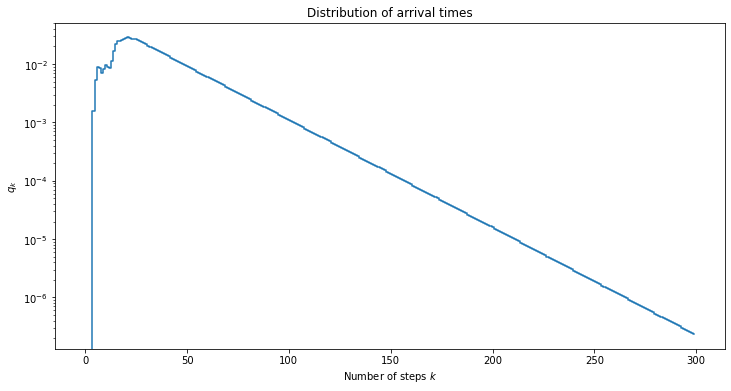

In [47]:
plt.step(range(len(qL)), qL, where='mid');
plt.yscale('log')
plt.title('Distribution of arrival times')
plt.xlabel('Number of steps $k$');
plt.ylabel('$q_k$');

The tail of the distribution is linear in the semilogarithmic plot, indicating that it follows an exponential distribution. For more detailed characterization, we could fit the distribution for $k>50$ to an exponential distribution; we leave this as an exercise.

#### Comparison with simulation

In [48]:
from chutes import multi_game_experiment

In [49]:
d = multi_game_experiment(num_games=20000, num_players=1, seed=1234567)

In [50]:
qE = np.zeros(max(d)+1, dtype=float)
for n in frozenset(d):
    qE[n] = d.count(n)
qE /= len(d)

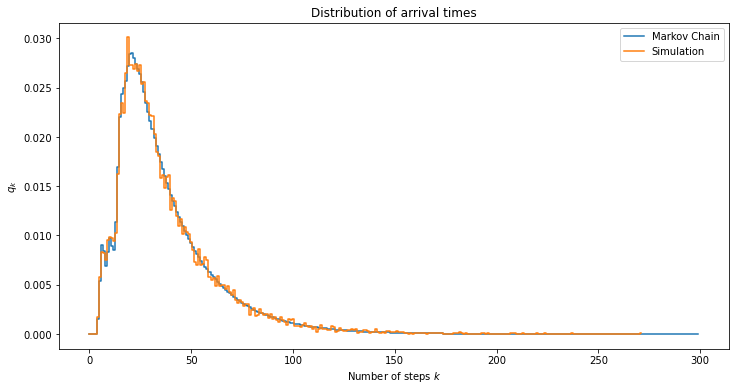

In [51]:
plt.step(range(len(qL)), qL, where='mid', label='Markov Chain');
plt.step(range(len(qE)), qE, where='mid', label='Simulation');
plt.title('Distribution of arrival times')
plt.xlabel('Number of steps $k$');
plt.ylabel('$q_k$');
plt.legend();

In [52]:
plt.step(range(len(qL)), qL, where='mid', label='Markov Chain');
plt.step(range(len(qE)), qE, where='mid', label='Simulation');
plt.title('Distribution of arrival times')
plt.xlabel('Number of steps $k$');
plt.ylabel('$q_k$')
plt.xlim(0, 100)
plt.legend();

Markov chain analysis and simulation are apparently in good agreement. This qualitative statement based on visual inspection (which may be misleading) should be substantiated by a proper statistical test, cf *Extensions* below.

#### Games with multiple players

In order to find the distribution of the arrival time for the first of $N$ (identical) players in a game, we can use results from [order statistics](http://en.wikipedia.org/wiki/Order_statistic). If $T_n$ is the random variable representing the arrival time of walker $n$, then we are interested in the distribution of $\min \{T_1, T_2, ..., T_N\}$, where all $T_n$ are independently and identically distributed according to the discrete distribution $q_k$. From [David and Nagaraja (1992, Eq 2.1.3)](http://books.google.no/books?id=bdhzFXg6xFkC&dq=Arnold,+B.+C.,+N.+Balakrishnan,+H.+N.+Nagaraja.+1992.+A+First+Course+in+Order+Statistics.+Wiley,+New+York.&hl=no&source=gbs_navlinks_s), we obtain the cumulative distribution of the minimum of $N$ random variables i.i.d. with cumulative distribution $Q_k$ as
$$R^{(N)}_k = 1 - ( 1 - Q_k )^N$$
and the corresponding distribution as
$$r^{(N)}_k = R^{(N)}_k - R^{(N)}_{k-1}\;.$$
See also [Evans et al (2006)](http://www.math.wm.edu/~leemis/2006informsjoc.pdf).

We consider a game with four players.

In [53]:
N = 4
RL = 1 - (1 - QL)**N
rL = np.zeros_like(RL)   # fiddle a little to avoid zero-indexing trouble
rL[1:] = np.diff(RL)

In [54]:
dN = multi_game_experiment(num_games=20000, num_players=4, seed=1234567)
rE = np.zeros(max(dN)+1, dtype=float)
for n in frozenset(dN):
    rE[n] = dN.count(n)
rE /= len(dN)

In [55]:
plt.step(range(len(rL)), rL, where='mid', label='Markov Chain');
plt.step(range(len(rE)), rE, where='mid', label='Simulation');
plt.title('Distribution of arrival times for first of {:d} walkers'.format(N))
plt.xlabel('Number of steps $k$');
plt.ylabel('$r_k$');
plt.legend();
plt.xlim(0, 75);

Also in this case theory and simulation appear to agree very well; see *Extensions* below for a note on statistical tests for distributions. As a sanity check, we check that no-one arrived in fewer than four moves, and that $R_k^{(4)}	\to1$ for $k	\to\infty$:

In [56]:
print(RL[3], RL[4])
print(1 - RL[-1])

0.0 0.006158565220760082
0.0


### Extensions

#### Statistical tests for distributions
Above, we compared distributions obtained numerically by Markov chain analysis with distributions obtained from simulations by visual inspection. While this is a useful first step (*always* look at your data before applying statistical analysis!), it may also be misleading. To draw solid conclusions, we need to apply statistical tests to check whether the simulation results follow the distribution obtained from Markov chain analysis.

For continuous random variables, e.g., variables following a Gaussian or exponential distribution, the proper test is the [Kolmogorov-Smirnov test](http://itl.nist.gov/div898/handbook/eda/section3/eda35g.htm), which is available as [`scipy.stats.kstest`](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html).

The distribution of game durations, though, is a discrete distribution and we need to apply the [$\chi^2$-test](http://itl.nist.gov/div898/handbook/eda/section3/eda35f.htm), which is available as [`scipy.stats.chisquare`](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html). In this test, we compare the number of times each game duration has been observed with the number predicted, $n_k=q_k\times N$, where $N$ is then number of games played. To be valid, the $\chi^2$-test requires that $n_k >5\; \forall k$. In order to ensure that this is fulfilled, we proceed as follows:

1. Find $k_{\mathrm{max}}$, the game duration for with highest probability $q_k$. The distribution for $k>k_{\mathrm{max}}$ is essentially the tail of the distribution, while the part $k<k_{\mathrm{max}}$ is the interesting part.
1. Find $k_{\mathrm{min}} < k_{\mathrm{max}}$, the game duration for which $q_k$ is smallest (but non-zero), to the left of the maximum.
1. Choose $N$ so that $N\times q_{k_{\mathrm{min}}}>5$.
1. Find $k_{\mathrm{tail}}$ as the largest $k$ for which both of the following conditions are fulfilled:

    1. $N\times q_k>5$
    1. $(1-Q_k)\times N>5$

   Condition A. ensures that the expectation for the rightmost bin, $k_{\mathrm{tail}}$ is more than 5, while B. ensures that the remaining tail, which we will collapse into a single bin, also has an expectation of at least 5.
1. Simulate $N$ games.
1. Each game duration $k$ forms one *bin* for the $\chi^2$-test, except that all game durations $k>k_{\mathrm{tail}}$ are combined in a single bin. The expectation for this bin is $n_{\mathrm{tail}}=(1-Q_{k_\mathrm{tail}})\times N$.
1. Apply the $\chi^2$-test to the data.

#### Modeling players with internal state
In order to treat players with internal state, such as resilient players (take extra step(s) after sliding down) or lazy players (take fewer step(s) after climbing up), we need to split every element of vector $p$ into two: one representing the probability of being in normal, and on of being in special mode at a given location. Matrices $M$ and $L$ then have twice as many rows and columns and become more complicated, although the design approach is the same.

#### Using sparse matrices
For very large matrices, it may be useful to consider *sparse matrix* implementations from SciPy, which do not store all the zeros elements in $M$ and $L$.

### Using more suitable color maps

- The color maps we used above were not optimal due to limited contrast
- We will look at better color maps here
- We first define functions to
    - create a propagator matrix M for a given game board
    - evolve the state of the game over time
    - extract the arrival-time distribution

In [57]:
def propagator(ladders=None, chutes=None, goal=90):
    ladders = ladders if ladders is not None else [(1, 40), (8, 10), (36, 52), 
                                                   (43, 62), (49, 79), (65, 82), 
                                                   (68, 85)] 
    chutes = chutes if chutes is not None else [(24, 5), (33, 3), (42, 30), 
                                                (56, 37), (64, 27), (74, 12), 
                                                (87, 70)]
    
    M = np.zeros((goal+1, goal+1))
    M[goal, goal] = 1
    M[goal, (goal-6):goal] = np.array([1., 2., 3., 4., 5., 6.]) / 6.
    for i in range(1, goal):
        M[i, max(0, i-6):i] = 1./6.
        
    L = M.copy()
    for start, dest in chutes + ladders:
        L[start, :] = 0.
        L[dest, :] += M[start, :]
        
    return L

In [58]:
def evolve(prop, num_moves, initial=None):
    r, c = prop.shape
    assert r == c, "Propagator must be square"
    if initial is None:
        initial = np.zeros(r)
        initial[0] = 1
    else:
        assert len(initial) == r, "Initial size wrong"
    
    p = np.zeros((r, num_moves+1))
    p[:, 0] = initial
    
    for k in range(1, num_moves+1):
        p[:, k] = np.dot(prop, p[:, k-1])
        
    return p    

In [59]:
def arrival_dist(p_evol):
    Q = p_evol[-1, :]
    q = np.zeros_like(Q)
    q[1:] = np.diff(Q)
    return q, Q

#### Propagator matrix—standard color map

In [60]:
prop90 = propagator()

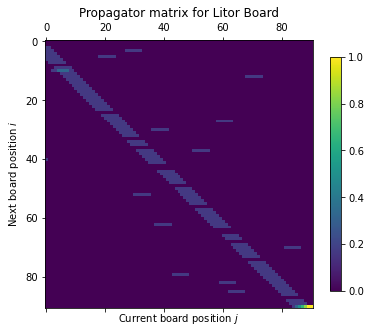

In [61]:
plt.matshow(prop90)
plt.xlabel('Current board position $j$');
plt.ylabel('Next board position $i$');
plt.title('Propagator matrix for Litor Board');
plt.colorbar(shrink=0.7);

- Problems with the figure above: 
    - all values in the matrix are either 0 or a multiple of 1/6
    - this is not clear from the color scale
    - actual values are difficult to read off
    - color scale is not linear in any sense
- Solution: Alternative color map
    - See [Choosing colormaps](http://matplotlib.org/users/colormaps.html) and [Colormaps reference](http://matplotlib.org/examples/color/colormaps_reference.html)
    - See also [this presentation on the default colormap in Matplotlib 2.0](https://bids.github.io/colormap/)
- Some of the examples below are based on ideas from
    - http://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar
    - http://pyhogs.github.io/colormap-examples.html

##### Step 1: Use a perceptually uniform color map

- Lightness changes uniformly over range of color map
- The `_r` suffix on the name reverses the color map, so that 0 is darkest
- For clarity, we use a small matrix and drop axis decorations

In [62]:
import matplotlib.cm as cm

In [64]:
propsmall = propagator(ladders=[(3, 5), (10, 15)], 
                       chutes=[(7, 2), (16, 12)], goal=20)

In [65]:
plt.matshow(propsmall, cmap=cm.YlGnBu_r)
plt.colorbar(shrink=0.7);

##### Step 2: Discrete color map with values 0, 1/6, 2/6, ..., 1

- Seven different colors needed
- We can just get a color map with the necessary number of levels

In [66]:
cm7 = cm.get_cmap('YlGnBu_r', 7)
plt.matshow(propsmall, cmap=cm7)
plt.colorbar(shrink=0.7);

- The axis label are now not very helpful
- We can change the placement of the labels

In [67]:
cm7 = cm.get_cmap('YlGnBu_r', 7)
plt.matshow(propsmall, cmap=cm7)
cax = plt.colorbar(shrink=0.7);
cax.set_ticks(np.linspace(0, 1, 7));

- Better, but it would be even nicer to place the markers in the center of the boxes and show fractions
- For $n$ boxes, the box centers are placed at

$$y_k = \frac{1}{2n} + \frac{k}{n} \quad k = 0, 1, \dots, n-1$$

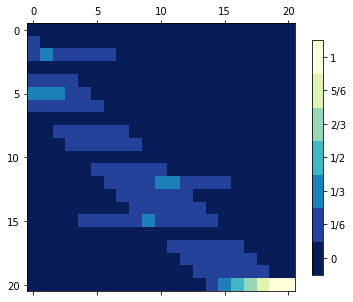

In [68]:
cm7 = cm.get_cmap('YlGnBu_r', 7)
plt.matshow(propsmall, cmap=cm7)
cax = plt.colorbar(shrink=0.7);
cax.set_ticks(np.arange(0., 7.) / 7. + 1./14.);
cax.set_ticklabels(('0', '1/6', '1/3', '1/2', '2/3', '5/6', '1'));

##### Step 3: change representation of zero probability for better contrast

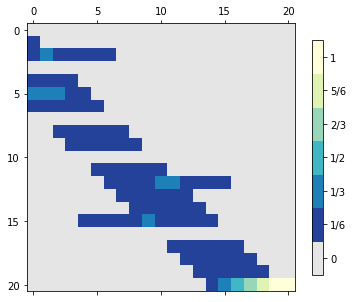

In [69]:
cm7 = cm.get_cmap('YlGnBu_r', 7)
cm7list = [cm7(i) for i in range(cm7.N)]
cm7list[0] = [0.9, 0.9, 0.9]
cm7mod = cm7.from_list('mymap', cm7list, cm7.N)
plt.matshow(propsmall, cmap=cm7mod)
cax = plt.colorbar(shrink=0.7);
cax.set_ticks(np.arange(0., 7.) / 7. + 1./14.);
cax.set_ticklabels(('0', '1/6', '1/3', '1/2', '2/3', '5/6', '1'));

#### Time evolution of residence probability

- We will use a similar color map as above for the time evolution, but with full resolution
- We will mark values below a certain limit with a separat color

In [70]:
p90 = evolve(prop90, 200)

In [71]:
import copy

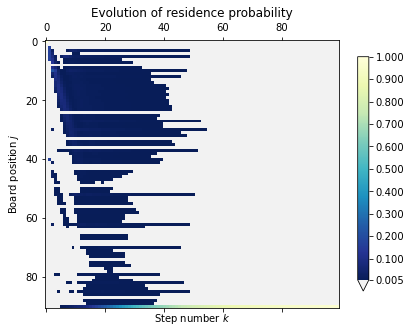

In [73]:
p_cutoff = 0.005

cm_p = copy.copy(cm.get_cmap('YlGnBu_r'))
cm_p.set_under((0.95, 0.95, 0.95))
plt.matshow(p90[:, :100], cmap=cm_p, vmin=p_cutoff)
plt.xlabel('Step number $k$');
plt.ylabel('Board position $j$');
plt.title('Evolution of residence probability');
cax = plt.colorbar(shrink=0.7, extend='min');
cax.set_ticks([p_cutoff] + list(np.arange(0.1, 1.01, 0.1)));

##### Step 4: Zooming in on parts of the color scale

- We can use different normalizations for the color scale to make important parts of the figure more visible
- Here, we use a power norm $x^\gamma$

In [74]:
from matplotlib.colors import PowerNorm

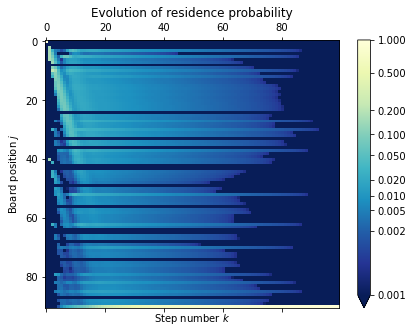

In [77]:
p_cutoff = 0.001
cm_p = copy.copy(cm.get_cmap('YlGnBu_r'))
cm_p.set_under((0.95, 0.95, 0.95))
plt.matshow(p90[:, :100], cmap=cm_p,
            norm=PowerNorm(gamma=0.2, vmin=p_cutoff, vmax=1))
plt.xlabel('Step number $k$');
plt.ylabel('Board position $j$');
plt.title('Evolution of residence probability');
cax = plt.colorbar(shrink=0.8, extend='min');
cax.set_ticks([p_cutoff, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]);